# Sentiment Analysis with GRU and Attention mechanism
*Student - Martiros Yeghiazaryan*

### Tasks

1.   Propose a neural network using GRU cells to predict sentiment
2.   Add an attention mechanism to this neural network
3.   Try to exploit the attention matrix and give some example



The dataset contain the following information:

* Product Name
* Brand Name
* Price
* Rating
* Reviews
* Review Votes

We are interested by the 'Reviews' (X) and by the 'Rating' (y)

The goal is to try to predict the 'Rating' after reading the 'Reviews'.

In [16]:
try:
    from jyquickhelper import add_notebook_menu 
except:
    !pip install jyquickhelper
    from jyquickhelper import add_notebook_menu
    
add_notebook_menu()

## Imports

In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
!pip install keras_tuner


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import keras_tuner as kt
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.strings
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (GRU, Activation, AveragePooling1D,
                                     Bidirectional, Dense, Dot, Dropout,
                                     Embedding, Flatten, Input, Permute,
                                     RepeatVector, TextVectorization,
                                     TimeDistributed)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import plot_model

In [21]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

## Importing the dataset

In [23]:
TRAIN = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/train.csv.gz").fillna(value="")
VAL = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/val.csv.gz").fillna(value="")
TEST = pd.read_csv("http://www.i3s.unice.fr/~riveill/dataset/Amazon_Unlocked_Mobile/test.csv.gz").fillna(value="")

TRAIN.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,Samsung Galaxy Note 4 N910C Unlocked Cellphone...,Samsung,449.99,4,I love it!!! I absolutely love it!! 👌👍,0.0
1,BLU Energy X Plus Smartphone - With 4000 mAh S...,BLU,139.0,5,I love the BLU phones! This is my second one t...,4.0
2,Apple iPhone 6 128GB Silver AT&T,Apple,599.95,5,Great phone,1.0
3,BLU Advance 4.0L Unlocked Smartphone -US GSM -...,BLU,51.99,4,Very happy with the performance. The apps work...,2.0
4,Huawei P8 Lite US Version- 5 Unlocked Android ...,Huawei,198.99,5,Easy to use great price,0.0


In [24]:
# Constructing X_train and y_train
X_train = np.array(TRAIN['Reviews']).reshape(-1,1)

ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
y_train = ohe.fit_transform(np.array(TRAIN['Rating']).reshape(-1,1))

X_train.shape, y_train.shape

c:\Users\Admin\.virtualenvs\test-6Bkx8LeP\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((5000, 1), (5000, 5))

In [25]:
# The same for val train
X_val = np.array(VAL['Reviews']).reshape(-1,1)
y_val = ohe.transform(np.array(VAL['Rating']).reshape(-1,1))

# The same for val test
X_test = np.array(TEST['Reviews']).reshape(-1,1)
y_test = ohe.transform(np.array(TEST['Rating']).reshape(-1,1))

In [26]:
X_test.shape, y_test.shape

((1000, 1), (1000, 5))

### Studying the length deistribution of the reviews

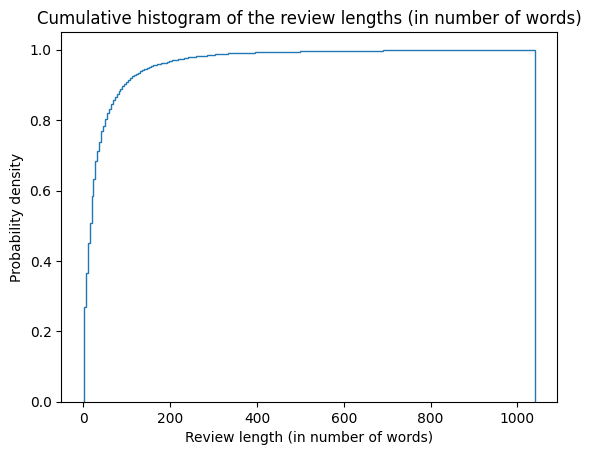

In [27]:
# Compute histogram of review lengths
review_lengths = [len(review[0].split(" ")) for review in X_train]
hist, bin_edges = np.histogram(review_lengths, bins='auto', density=True)

# Compute cumulative distribution
cumulative = np.cumsum(hist * np.diff(bin_edges))

# Plot cumulative histogram
plt.hist(review_lengths, bins='auto', density=True, histtype='step', cumulative=True)
plt.title('Cumulative histogram of the review lengths (in number of words)')
plt.xlabel('Review length (in number of words)')
plt.ylabel('Probability density')
plt.show()



We simply spit out the reviews using white space, which is a straightforward but nonetheless informative strategy. According to the plot above, the'max len' parameter should be 150 in order to obtain $95\%$ of the evaluations that are not truncated.


In [28]:
# Constants
nb_classes = y_train.shape[1]
vocab_size = 10 ** 4  # Maximum vocab size (a commonly used maximum vocabulary size in NLP tasks)
embedding_size = 20 # Embedding size (may be appropriate if the input texts are long or complex) usually smaller than 300
recurrent_size = 68 # Recurrent size (may be appropriate if the input sequences are not very long or complex)
hidden_size = recurrent_size // 4    # Hidden layer
dropout_rate = 0.2   # Dropout rate for regularization (usually between 0.1 and 0.25)
max_len = 150        # Sequence length to pad the outputs to based on the distribution of the review lengths (deduced from the length distribution study)
learning_rate = 0.0075

# Preprocessing the text data

In [29]:
# Creating the vectorized layer.
vectorize_layer = TextVectorization(max_tokens=vocab_size,
                                    standardize="lower_and_strip_punctuation",
                                    output_mode='int',
                                    output_sequence_length=max_len)

In [30]:
# Fittin vectorized layer on train
vectorize_layer.adapt(X_train)

In [31]:
vectorize_layer(X_train[0])

<tf.Tensor: shape=(1, 150), dtype=int64, numpy=
array([[   3,   52,    4,    3,  345,   52,    4, 4907,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,   

In [32]:
# Plotting history
def babysit(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,6))

    # summarize history for loss
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['loss train', 'loss val'], loc='best')

    # summarize history for loss
    ax2.plot(history.history['f1_score'])
    ax2.plot(history.history['val_f1_score'])
    ax2.set_title('model F1')
    ax2.set_ylabel('F1')
    ax2.set_xlabel('epoch')
    ax2.legend(['f1 train', 'f1 val'], loc='best')

    plt.show()
    
#babysit(history)

## Simple GRU model

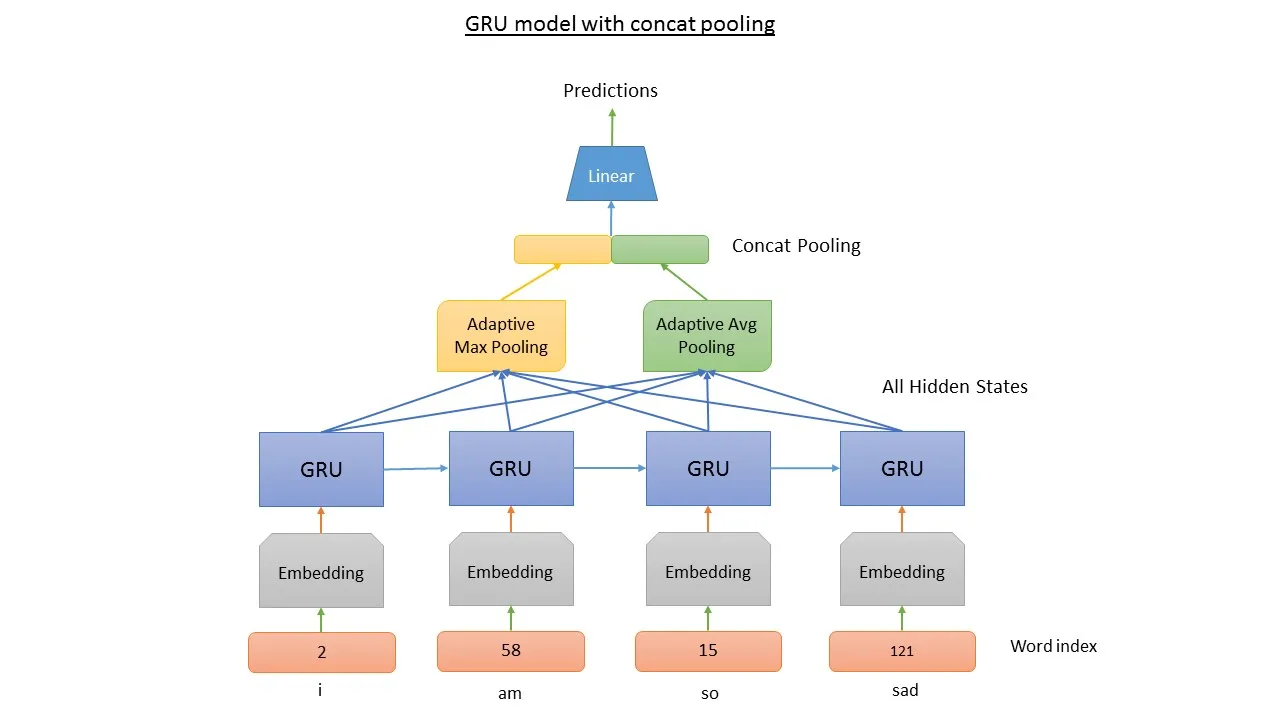

Source - https://medium.com/@sonicboom8/sentiment-analysis-with-variable-length-sequences-in-pytorch-6241635ae130

In [33]:
# Define the network
def build_model():
    input_ = Input(shape=(1,), dtype=tf.string)
    x = vectorize_layer(input_)
    x = Embedding(vocab_size, embedding_size, name="Embedding")(x)
    x = GRU(
            recurrent_size,
            return_sequences=False,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate,
        )(x)
    x = Dense(hidden_size, activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    output_ = Dense(nb_classes, activation="softmax", dtype=tf.float64)(x)
    model = Model(input_, output_)
    return model


model = build_model()

In [34]:
# summarize the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 150)              0         
 torization)                                                     
                                                                 
 Embedding (Embedding)       (None, 150, 20)           200000    
                                                                 
 gru (GRU)                   (None, 68)                18360     
                                                                 
 dense (Dense)               (None, 17)                1173      
                                                                 
 dropout (Dropout)           (None, 17)                0         
                                                             

In [35]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file="gru-model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [36]:
# Compiling the model 

f1 = F1Score(num_classes=nb_classes, average="macro", threshold=None)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss="categorical_crossentropy", metrics=[f1])

In [37]:
# fitting the model using early stopping
es = EarlyStopping(
    monitor="val_f1_score",
    mode="max",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=4000,
    callbacks=[es],
    verbose=1,
)

Epoch 1/4000
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
157/157 [==============================] - 20s 111ms/step - loss: 1.3161 - f1_score: 0.1484 - val_loss: 1.2648 - val_f1_score: 0.1434
Epoch 2/4000
157/157 [==============================] - 22s 137ms/step - loss: 1.2910 - f1_score: 0.1438 - val_loss: 1.2631 - val_f1_score: 0.1432
Epoch 3/4000
157/157 [==============================] - 19s 123ms/step - loss: 1.2755 - f1_score: 0.1613 - val_loss: 1.2944 - val_f1_score: 0.1473
Epoch 4/4000
157/157 [==============================] - 19s 118ms/step - loss: 1.2616 - f1_score: 0.1714 - val_loss: 1.4620 - val_f1_score: 0.2193
Epoch 5/4000
157/157 [==============================] - 17s 107ms/step - loss: 1.1072 - f1_score: 0.2340 - val_loss: 1.0581 - val_f1_score: 0.2749
Epoch 6/4000
157/157 [==============================] - 17s 108m

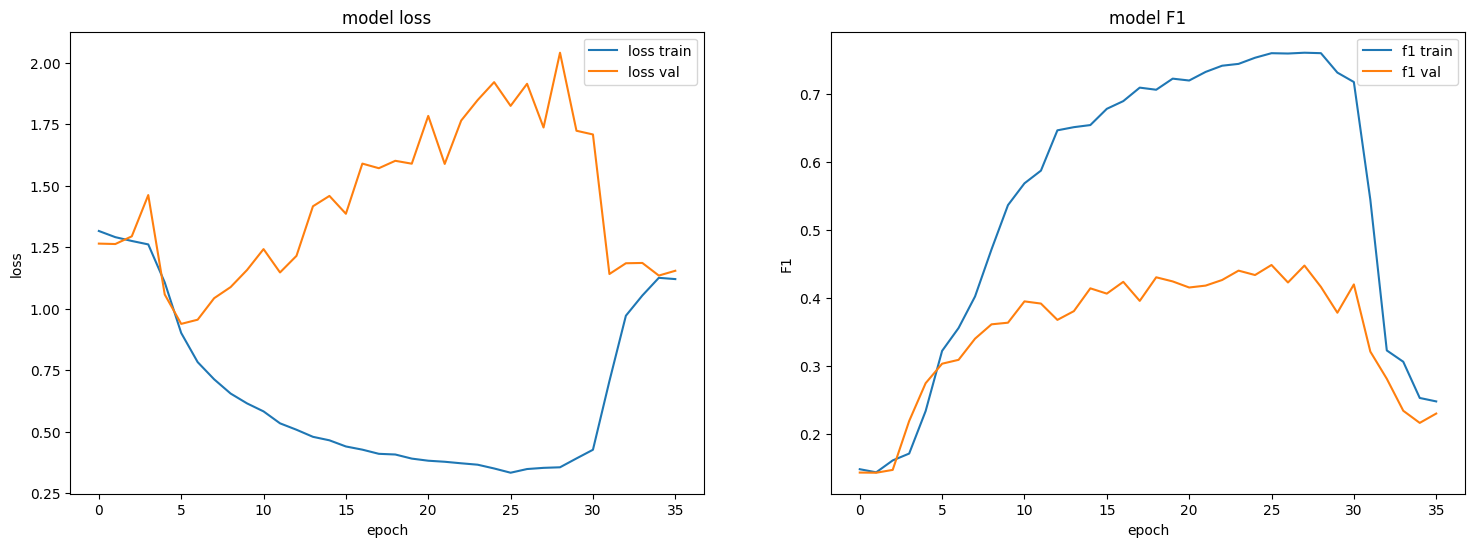

In [38]:
# plot history

babysit(history)

In [39]:
# Evaluating  the model

f1.update_state(y_test, model.predict(X_test))
print(f"F1: {f1.result().numpy()}")

32/32 [==============================] - 1s 17ms/step
F1: 0.33221349120140076


## Attention with GRU network

Here is only one GRU layer used in this case.

In [40]:
# Building the model 

def build_model():

    # The input is going to be the review
    input_ = Input(shape=(1, ), name="input", dtype=tf.string)

    # Transform the review in a list of tokenID
    vect = vectorize_layer(input_)

    # Adding the Keras Embedding
    embedding = Embedding(vocab_size,
                          embedding_size, 
                          weights=None,  # means that the embedding layer is initialized with random weights and is not pre-trained on any external dataset
                          trainable=True,# means that the weights of the embedding layer are trainable during model training
                          name='embedding'
                         )(vect)
    
    rnn = GRU(recurrent_size, return_sequences=True, 
               return_state=False,
               dropout=dropout_rate, recurrent_dropout=dropout_rate)(embedding)

    
    # The GRU also has an internal state like LSTM, which is typically denoted by h, but unlike the LSTM, it does not have a separate cell state.
    # The internal state of a GRU is typically a single vector h.

    # Attention layer
    attention = Dense(1, activation='tanh')(rnn)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)

    # The result of these three lines is a set of attention weights that can be used to compute a weighted sum of the hidden states of the RNN layer, 
    # where the weights are the attention probabilities. This weighted sum is then passed through a dense layer and 
    # a final softmax activation function to obtain the output of the model.
  

    # To be able to do the multiplication
    attention = RepeatVector(recurrent_size)(attention)
    attention = Permute([2, 1])(attention)
  
    # Application of attention on the output of the RNN
    sent_representation = Dot(axes=1, normalize=False)([rnn, attention])
    
    # Flatten to enter the Dense
    flatten = Flatten()(sent_representation)
    
    # Dense for classification with 1 hidden layer
    hidden_dense = Dense(hidden_size, activation="relu")(flatten)
    hidden_dense = Dropout(dropout_rate)(hidden_dense)

    # Classification and output
    output_ = Dense(nb_classes, activation='softmax')(hidden_dense)
    
    # Build the model
    model = Model(inputs=input_, outputs=output_)
    
    return model

model = build_model()

When a recurrent layer (such as LSTM or GRU) has **return_sequences=True** and **return_state=False**, it means that the layer will return the output at each timestep, but not the internal state of the layer.

In our case of sentiment analysis, this can be useful because it allows you to obtain a representation of the input sequence at each timestep. This can then be used in later layers of the model to learn patterns and make predictions. The output of the GRU layer with **return_sequences=True** is passed through an attention layer to compute a weighted average of the hidden states, which is used as the final representation of the input sequence.

If **return_sequences** were set to False, the layer would only return the output at the final timestep, which would limit the model's ability to learn patterns across the entire input sequence.

In [41]:
# Plotting the model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='GRU_with_attention.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [42]:
# Compiling the model
f1 = F1Score(num_classes=nb_classes, average="macro", threshold=0.5)
op = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=op, loss='categorical_crossentropy', metrics=[f1])

Choosing 0.5 as the **threshold** for the F1 score assumes an equal trade-off between precision and recall in the binary classification problem. 

**beta_1** is the exponential decay rate for the first moment estimates, which determines how much to weight the past gradient values.

**beta_2** is the exponential decay rate for the second moment estimates, which determines how much to weight the past squared gradient values.

**epsilon** is a small value added to the denominator for numerical stability.

These values are typically set to the defaults recommended by the authors of the Adam optimizer, which are **beta_1=0.9, beta_2=0.999, and epsilon=1e-8**. These values have been found to work well in practice for a wide range of optimization problems.

In [43]:
es = EarlyStopping(monitor='val_f1_score', mode='max', patience=5, restore_best_weights=True, verbose=2)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val), 
                    epochs=4000, callbacks=[es], verbose=1)

Epoch 1/4000
157/157 [==============================] - 22s 122ms/step - loss: 1.2304 - f1_score: 0.1346 - val_loss: 1.1110 - val_f1_score: 0.1881
Epoch 2/4000
157/157 [==============================] - 19s 120ms/step - loss: 0.9695 - f1_score: 0.2500 - val_loss: 0.9155 - val_f1_score: 0.2639
Epoch 3/4000
157/157 [==============================] - 19s 122ms/step - loss: 0.8481 - f1_score: 0.2948 - val_loss: 0.9278 - val_f1_score: 0.3007
Epoch 4/4000
157/157 [==============================] - 18s 116ms/step - loss: 0.7509 - f1_score: 0.3300 - val_loss: 1.0163 - val_f1_score: 0.2796
Epoch 5/4000
157/157 [==============================] - 18s 115ms/step - loss: 0.6938 - f1_score: 0.3700 - val_loss: 0.9776 - val_f1_score: 0.2847
Epoch 6/4000
157/157 [==============================] - 22s 142ms/step - loss: 0.6197 - f1_score: 0.4052 - val_loss: 1.1446 - val_f1_score: 0.3232
Epoch 7/4000
157/157 [==============================] - 21s 136ms/step - loss: 0.5925 - f1_score: 0.4762 - val_loss: 1

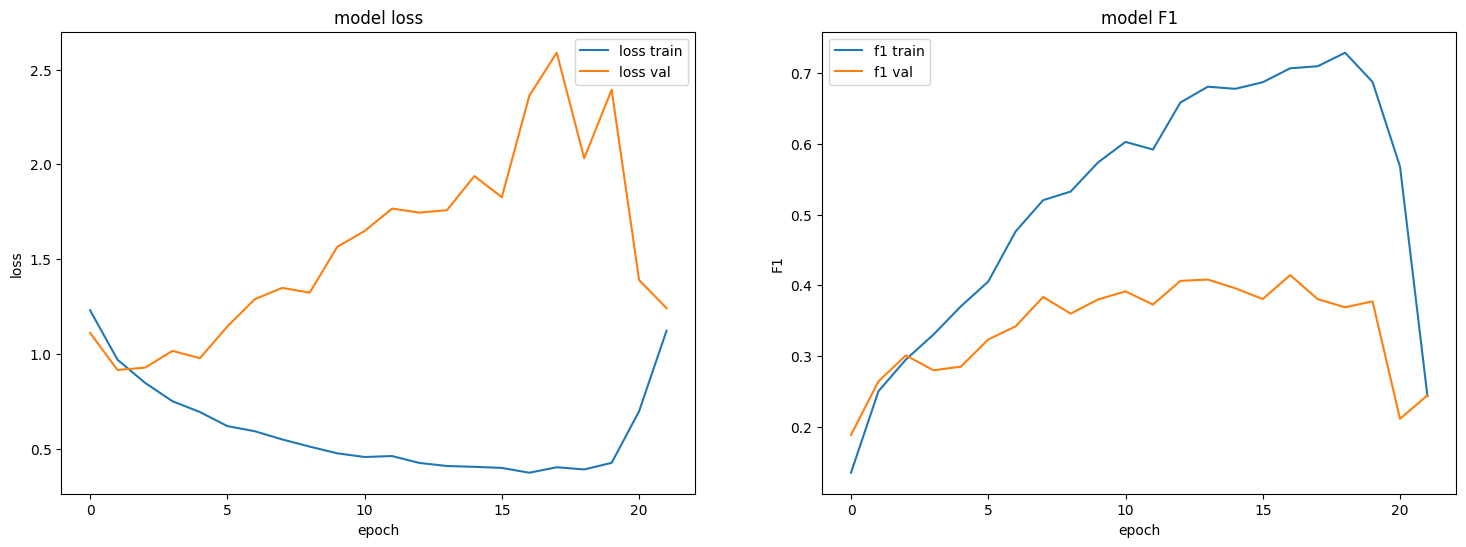

In [44]:
# plot history
babysit(history)

The accuracy of the model on the test set.

In [45]:
# Evaluate the model
f1.update_state(y_test, model.predict(X_test))
print('F1: %f' % (f1.result().numpy()))

32/32 [==============================] - 1s 18ms/step
F1: 0.334478


## Using the Attentionnal model

In the cell below, we reproduce our existing model until the Activation layer only.

In [46]:
# GET ATTENTION MODEL
def get_attention_model(model):
    attention_layer_indice = 0
    for layer in model.layers:
        print(type(layer))
        if type(layer) is Activation:
            break
        else:
            attention_layer_indice += 1

    # Create an attention model
    return Model(inputs=model.layers[0].input, outputs=model.layers[attention_layer_indice].output)

The **get_attention_model** function extracts the attention mechanism layer from a given model by searching for the first activation layer in the model's layers. It then returns a new model with the same inputs as the original model and the output of the attention layer as its output.

In [47]:
# PLOT ATTENTION MODEL from classifier model with ATTENTION
attention_model = get_attention_model(model)
plot_model(attention_model, show_shapes=True, show_layer_names=True, to_file='model_get_attention.png')

<class 'keras.engine.input_layer.InputLayer'>
<class 'keras.layers.preprocessing.text_vectorization.TextVectorization'>
<class 'keras.layers.core.embedding.Embedding'>
<class 'keras.layers.rnn.gru.GRU'>
<class 'keras.layers.core.dense.Dense'>
<class 'keras.layers.reshaping.flatten.Flatten'>
<class 'keras.layers.core.activation.Activation'>
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [48]:
# GET ATTENTION
attentions = attention_model.predict(X_val[1])
attentions

1/1 [==============================] - 0s 282ms/step


array([[0.00607493, 0.00607422, 0.00613958, 0.00607412, 0.00607412,
        0.00607412, 0.00607412, 0.00607413, 0.00607441, 0.00607847,
        0.00612144, 0.00642332, 0.00731723, 0.0077195 , 0.00723283,
        0.00685686, 0.00675101, 0.00677451, 0.00679296, 0.00677506,
        0.00675631, 0.00674551, 0.00673425, 0.00672352, 0.00671673,
        0.00671246, 0.0067089 , 0.00670608, 0.00670412, 0.00670263,
        0.00670139, 0.0067004 , 0.00669964, 0.00669903, 0.00669852,
        0.0066981 , 0.00669776, 0.00669747, 0.00669722, 0.00669701,
        0.00669682, 0.00669666, 0.0066965 , 0.00669636, 0.00669623,
        0.0066961 , 0.00669598, 0.00669586, 0.00669574, 0.00669563,
        0.00669552, 0.00669541, 0.0066953 , 0.00669519, 0.00669509,
        0.00669499, 0.00669489, 0.00669479, 0.00669469, 0.0066946 ,
        0.0066945 , 0.00669441, 0.00669432, 0.00669424, 0.00669415,
        0.00669407, 0.00669399, 0.00669391, 0.00669383, 0.00669375,
        0.00669368, 0.00669361, 0.00669354, 0.00

The trained attention model generates attention scores for each input token or word. The resulting attentions array contains the attention scores for each token in the input sequence. These attention scores can be visualized to better understand which parts of the input sequence the model is paying the most attention to during prediction.

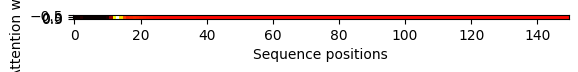

In [49]:
# Create a heatmap of the attention weights
plt.imshow(attentions, cmap='hot', interpolation='nearest')
plt.xlabel('Sequence positions')
plt.ylabel('Attention weights')
plt.show()

In [50]:
# GET ATTENTION for each WORD

from sklearn import preprocessing

def get_attention(X, y, prediction, attention, N=5):
    # normalize attention (without the padding part)
    normalized_attention = preprocessing.QuantileTransformer().fit_transform(attention)
  
    results = []
    for i, (X_, y_, p_, a_) in enumerate(zip(X, y, prediction, normalized_attention)):
        if i>N:
            break
        # build result
        result_entry = {}
        result_entry["prediction"] = (np.argmax(y_), np.argmax(p_))
        result_entry["original"] = X_.item()
        result_entry["sentence"] = []
        for j, word in enumerate(vectorize_layer(X_).numpy().flatten().tolist()):
            word_obj = {}
            if word==0:
                break
            word_obj[vectorize_layer.get_vocabulary()[word]] = a_[j].item()
            result_entry["sentence"].append(word_obj)
            
        results += [result_entry]
    return results

sentences_with_attention = get_attention(X_val, y_val,
                                         model.predict(X_val),
                                         attention_model.predict(X_val),
                                         10)   
sentences_with_attention[1]

32/32 [==============================] - 1s 16ms/step


{'prediction': (4, 4),
 'original': 'Excellent,very good Very fast',
 'sentence': [{'[UNK]': 0.5065065026283264},
  {'good': 0.5835835933685303},
  {'very': 0.7847847938537598},
  {'fast': 0.5655655860900879}]}

We track how much focus our algorithm gives to a set of test words. The model provides "good","very" and "fast" a lot of attention. \
This makes sense because it is a significant indicator that suggests the evaluation will be favorable. The model would have paid less attention to them if the terms were more uncertain.

For better understanding, we highlight in green the words with an attention score > 0.75 (indicating the model gives them a lot of attention), red the words with an attention score 0.25 (indicating a low attention score), and dark the remaining words. \
The `[UNK]` phrases are those that the model is unfamiliar with (i.e. they are not part of the vocabulary). Some of them would stop being unknown to our model if we increased the vocabulary size (and thereby the model complexity).

In [51]:
%pip install -q colorama


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [53]:
# convert prediction with attention to colored text

import colorama
from colorama import init
init()
from colorama import Fore, Style

def print_colored_text(sentences_with_attention):
    threshold = 0.75
    classes = []
    print(Fore.GREEN + Style.BRIGHT + "In green, the most important word\n\n" + Style.RESET_ALL)

    for i, sentence in enumerate(sentences_with_attention):
        # Retrieve the class of this sentence
        original_class, predicted_class = sentence["prediction"]

        # Retrieve all the words and weights of this sentence
        words, weights = [], []
        for item in sentence["sentence"]:
            for word, weight in item.items():
                words.append(word)
                weights.append(float(weight))

        size = 0
        print(sentence["original"])
        for j, word in enumerate(words):
            if size != 0 and j != 0 and word != "," and word != ".":
                print(" ", end="")
            if weights[j] > threshold:
                print(Fore.GREEN + Style.BRIGHT + word + Style.RESET_ALL, end=" ")
            elif weights[j] < (1 - threshold):
                print(Fore.RED + Style.BRIGHT + word + Style.RESET_ALL, end=" ")
            else:
                print(Fore.LIGHTBLACK_EX + word + Style.RESET_ALL, end=" ")
            size += len(word) + 1
            if size > 80:
                print()
            size = 0

        print("\n")

print_colored_text(sentences_with_attention)

In green, the most important word


Pretty good
pretty good 

Excellent,very good Very fast
[UNK] good very fast 

This was a replacement. We had a POS Samsung from Cincinnati Bell. That phone was the worst thing we ever owned! This HTC seems to be built to last. It is small. Dont plan on rocking a lot of video. However, it is an Andriod and I think my wife likes it. It feels sturdy too. We bought it unlocked. All we had to do was insert the SIM card. It took about 2min to get it all set up. Very nice! I would give it 4-stars but the internal memory will eventually be an issue.
this was a replacement we had a pos samsung from [UNK] [UNK] that phone was the worst thing we ever owned this htc seems to be built to last it is small dont plan on [UNK] a lot of video however it is an andriod and i think my wife likes it it feels sturdy too we bought it unlocked all we had to do was insert the sim card it took about [UNK] to get it all set up very nice i would give it [UNK] but the internal m